# Pair Correlation Analysis of Fluorescence Fluctuations using Python

**A tutorial using Python and scientific libraries to implement pair correlation analysis of a big time series of images from fluorescence microscopy on a personal computer.**

by [Christoph Gohlke](http://www.lfd.uci.edu/~gohlke/), Laboratory for Fluorescence Dynamics, University of California, Irvine

October 18, 2016

This document is released under the creative commons [Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/) license.

## Abstract

Spatiotemporal analysis of fluorescence fluctuations of optical microscopy measurements on living samples is a powerful tool that can provide insight into dynamic molecular processes of high biological relevance (Di Rienzo et al., 2016).

Paired correlation analysis of fluorescence microscopy image time series acquired using very fast cameras is one of the emerging and promising spatiotemporal techniques. However, it is computationally very expensive and the analysis of big image data sets used to take hours or be impractical on personal computers.

In this tutorial we will use the open-source Python programming language and scientific libraries to compute the paired correlation analysis of a large time series of fluorescence images acquired with Selective Plane Illumination Microscopy (SPIM) in reasonable time.

First we will implement a function to calculate the cross-correlation of two time series. We demonstrate the limitations of Python for efficient numerical computations and several ways to overcome them.

Next we will implement the pair correlation analysis of a small simulated image and optimize its speed by almost two orders of magnitude.

Finally, we will use the function to analyze a multi-gigabyte image time series in small, overlapping chunks.

This is a tutorial on computing pair correlations in big images. Refer to the references on how the computed pair correlations can be analyzed and visualized to study molecular flow in cells.

## Requirements

* Familiarity with pair correlation analysis of fluorescence fluctuations (e.g. Gratton and Digman lectures).
* Familiarity with programming and nD array computing (e.g. Matlab, numpy).
* Familiarity with signal processing, time and frequency domain.
* CPython >= 3.4 and libraries: Jupyter, IPython, numpy, scipy, matplotlib, scikit-image, dask, Cython, numba, and tifffile.py.
* A Python distutils compatible C compiler: Visual Studio or gcc.

## The Challenge

The challenge is to **compute the pair correlation analysis of a large time series of images using Python on a personal computer in reasonable time**.

We have a 34.5 GB time series of SPIM images of a biological cell as **35,000 TIFF files of 1024x512 16-bit greyscale samples** each:

![image timeseries](image_timeseries.png)

As part of molecular flow analysis, we need to **cross-correlate the time series at each pixel of the image with all its neighbors at a specific radius**:

![image pair correlation analysis](image_pair_correlation_analysis.png)

For a radius of 6 there are 32 neighbor pixels. To analyze an image of 1024x512 pixels the **number of cross correlation calculations needed is 16,192,000** (`(1024-2*6)*(512-2*6)*32`). The image borders of 6 pixels are excluded.

We would like to perform the cross correlation calculations on the data set in **about 15 minutes**.

We have a modern notebook or desktop computer with **4 CPU cores, 8 GB RAM, and SSD** minimum, running a 64-bit OS with a scientific Python 3.5 distribution and a C compiler installed.

To compute 16,192,000 cross-correlations on 4 CPU cores in 15 minutes, **a single cross-correlation computation must finish in about 220 µs** (`4*15*60*1000*1000/16192000`).

Here is a **pseudo code for the image pair correlation function (ipcf)** analysis:

In [1]:
def ipcf_reference(image_timeseries, circle_coordinates, bins):
    """Return pair correlation analysis of an image time series.
    
    Cross-correlate the time series of each pixel of the image 
    with all its neighbors at a certain radius and return all 
    the smoothed and log-binned correlation curves.
    
    """
    ntimes, height, width = image_timeseries.shape
    npoints = len(circle_coordinates)
    radius = circle_coordinates[0, 0]
    
    result = zeros((height-2*radius, width-2*radius, npoints, len(bins)), 
                   'float32')
    
    for y in range(radius, height-radius):
        for x in range(radius, width-radius):
            a = image_timeseries[:, y, x]
            for i in range(npoints):
                u, v = circle_coordinates[i]
                b = image_timeseries[:, y+v, x+u]
                c = correlate(b, a)
                result[y-radius, x-radius, i] = smooth(average(c, bins))

    return result


# functions that need to be implemented

def correlate(a, b):
    """Return cross-correlation of two vectors."""
    ...

def average(c, bins):
    """Return averaged chunks of vector."""
    ...

def smooth(c):
    """Return smoothed vector."""
    ...

def circle(npoints, radius):
    """Return circle coordinates."""
    ...

def logbins(size, nbins):
    """Return up to nbins exponentially increasing integers from 1 to size."""
    ...

## Outline

### 1. Implement a fast cross-correlation function

In this section we will

* review the mathematical definition and some properties of cross-correlation.
* implement a cross-correlation function in pure Python.
* compare its speed with an implementation in C.
* use Python libraries to speed up the cross-correlation calculation: threading, numpy, scipy, numba, and Cython.
* use the cross-correlation theorem, Cython, and the fft2d C library to implement a very fast circular correlation function.

Along the way we'll learn

* about CPython and its limitations for numerical computations.
* to write Python C extensions and interface with C libraries using Cython.
* to use the Jupyter notebook to interactively manage data, code, visualizations, and explanatory text.

### 2. Implement pair correlation analysis of small image time series

The techniques learned in the first section are applied to implement the pair correlation analysis of a small simulated image time series.

In this section we will

* load and explore a time series of images from a simulation of fluorescence fluctuations.
* implement functions to average and smooth cross-correlation results for image fluctuation analysis.
* run the reference implementation of pair correlation analysis.
* visualize the result of the image pair correlation analysis.
* optimize the algorithm and implementation of the image pair correlation function.

The optimized implementation of the image pair correlation function runs ~60 times faster than the reference implementation.

### 3. Implement out-of-core pair correlation analysis of big image time series

In this section we demonstrate some methods to process data that fit on disk but are larger than RAM, a.k.a. out-of-core processing.

We will

* interactively browse the 34.5 GB image time series consisting of 35,000 TIFF files.
* semi-automatically select a subset of the data for further analysis using the scikit-image library.
* save the selection as an ImageJ hyperstack TIFF file.
* memory-map the data in the ImageJ hyperstack file to a numpy array.
* in-place correct the time series for photobleaching.
* use the dask library to chop big data in smaller, overlapping blocks/chunks and schedule the analysis of individual blocks.
* run the image pair correlation function implemented in the second part on overlapping blocks of the memory-mapped data.

---
## 1. Implement a fast cross-correlation function

In this section we will implement a fast 1D cross-correlation function. 

The goal is to perform a single cross-correlation of two long vectors in about 200 µs.

### Definition of cross-correlation

The **unnormalized discrete correlation of two sampled functions** $a$ and $b$ as generally defined in signal processing texts (e.g. [numpy.correlate](http://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html) and [MATLAB xcorr](https://www.mathworks.com/help/signal/ref/xcorr.html)) is:

$$c_{ab}[delay] = \sum_n a[n+delay] \cdot conj(b[n])$$

This definition is not unique and sometimes correlation may be defined differently (e.g. [Wikipedia](https://en.wikipedia.org/wiki/Cross-correlation)):

$$c'_{ab}[delay] = \sum_n conj(a[n]) \cdot b[n+delay],$$

which is related to the first definition:

$$c'_{ab}[delay] = c_{ab}[-delay] = c_{ba}[delay]$$

### Linear and circular correlation

There are two ways of dealing with **out of bounds $delay$ values**: 

* for **linear correlation** the out of bounds indices are set to zero (zero padding):

In [2]:
a = [1, 2, 3]
b = [4, 8, 16]

c = [       0 * b[0]  +         0 * b[1]  +  a[2 - 2] * b[2],  # delay -2
            0 * b[0]  +  a[1 - 1] * b[1]  +  a[2 - 1] * b[2],  # delay -1
     a[0 + 0] * b[0]  +  a[1 + 0] * b[1]  +  a[2 + 0] * b[2],  # delay  0
     a[0 + 1] * b[0]  +  a[1 + 1] * b[1]  +         0 * b[2],  # delay  1
     a[0 + 2] * b[0]  +         0 * b[1]  +         0 * b[2]]  # delay  2

print(c)

[16, 40, 68, 32, 12]


* for **circular correlation** the out of bounds indices are wrapped around:

In [3]:
c = [a[0 - 2] * b[0]  +  a[1 - 2] * b[1]  +  a[2 - 2] * b[2],  # delay = -2
     a[0 - 1] * b[0]  +  a[1 - 1] * b[1]  +  a[2 - 1] * b[2],  # delay = -1
     a[0 + 0] * b[0]  +  a[1 + 0] * b[1]  +  a[2 + 0] * b[2],  # delay = 0
     a[0 + 1] * b[0]  +  a[1 + 1] * b[1]  +  a[(2+1)%3]*b[2],  # delay = 1
     a[0 + 2] * b[0]  +  a[(1+2)%3]*b[1]  +  a[(2+2)%3]*b[2]]  # delay = 2

print(c)

[48, 52, 68, 48, 52]


The **circular correlation can calculate linear correlation by zero-padding the vectors**.

In [4]:
a = [0, 1, 2, 3, 0]
b = [0, 4, 8, 16, 0]

c = [a[-2]*b[0] + a[-1]*b[1] + a[0]*b[2] + a[1]*b[3] + a[2]*b[4],  # delay = -2
     a[-1]*b[0] + a[ 0]*b[1] + a[1]*b[2] + a[2]*b[3] + a[3]*b[4],  # delay = -1
     a[ 0]*b[0] + a[ 1]*b[1] + a[2]*b[2] + a[3]*b[3] + a[4]*b[4],  # delay = 0
     a[ 1]*b[0] + a[ 2]*b[1] + a[3]*b[2] + a[4]*b[3] + a[0]*b[4],  # delay = 1
     a[ 2]*b[0] + a[ 3]*b[1] + a[4]*b[2] + a[0]*b[3] + a[1]*b[4]]  # delay = 2

print(c)

[16, 40, 68, 32, 12]


In this tutorial the length of the correlation functions will be the same as the equal length input arrays, e.g. `[40, 68, 32]` respectively `[52, 68, 48]` for above examples.

### Properties of cross-correlation

Some properties of the cross-correlation function are relevant for the pair correlation calculations:

* According to the **cross correlation theorem**, the cross-correlation ($\star$) of functions $a(t)$ and $b(t)$ can be calculated using the Fourier transform $\mathcal{F}\{\}$:

    $$ a\star b = \mathcal{F}^{-1}(\mathcal{F}\{a\} \cdot (\mathcal{F}\{b\})^*)$$

    where $()^*$ denotes the complex conjugate. 
    For long vectors this is faster to calculate than the sliding dot product.


* The cross-correlation of functions $a(t)$ and $b(t)$ is equivalent to the **convolution** ($*$) of $a(t)$ and $b^*(-t)$:

    $$ a\star b = a*b^*(-t),$$

    where $b^*$ denotes the conjugate of $b$.


* For real valued input the following symmetry applies:

$$c_{ab}[delay] = c_{ba}[-delay]$$

* The discrete **autocorrelation** of a sampled function is the discrete **correlation of  the function with itself**. It is always symmetric with respect to positive and negative delays.

### Implement cross-correlation in pure Python

Let's implement the discrete linear correlation function in pure Python using the **sliding dot product** as defined previously:

$$c_{ab}[delay] = \sum_n a[n+delay] * conj(b[n])$$

In [5]:
def dot(a, b, start, stop, delay):
    """Return the dot product of two sequences in range."""
    sum = 0
    for n in range(start, stop):
        sum += a[n + delay] * b[n]
    return sum


def correlate_python(a, b):
    """Return correlation of two one-dimensional sequences."""
    size = len(a)
    maxdelay = size // 2
    
    # allocate output array
    c = [None] * size

    # negative delays
    for delay in range(-maxdelay, 0):
        c[delay + maxdelay] = dot(a, b, -delay, size, delay)

    # positive delays
    for delay in range(0, maxdelay + size % 2):
        c[delay + maxdelay] = dot(a, b, 0, size-delay, delay)

    return c

It is always good practice to write tests to verify code:

In [6]:
def test_correlate(correlate):
    """Test linear correlate function using known result."""
    # uneven lengths
    c = correlate([1, 2, 3], [4, 8, 16])
    assert list(c) == [40, 68, 32], c
    
    # even lengths
    c = correlate([1, 2, 3, 4], [5, 6, 7, 8])
    assert list(c) == [23, 44, 70, 56], c

In [7]:
test_correlate(correlate_python)

The tests passed. Let's time the cross-correlation of two random vectors of length 8192:

In [8]:
import random

a = [random.random()-0.5 for _ in range(2**13)]
b = [random.random()-0.5 for _ in range(2**13)]

%time c = correlate_python(a, b)

Wall time: 5.81 s


This implementation is about **30,000 times slower than desired** (~200 µs) for our paired correlation image analysis task.

### Plot autocorrelation

Let's use the [matplotlib](http://matplotlib.org/) library to plot the auto-correlation of a random sequence:

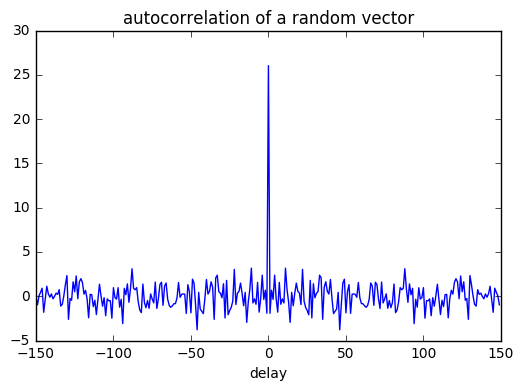

In [9]:
%matplotlib inline

from matplotlib import pyplot

a = [random.random()-0.5 for _ in range(300)]
c = correlate_python(a, a)

pyplot.title("autocorrelation of a random vector")
pyplot.xlabel("delay")
delays = list(range(-len(a) // 2,  len(a) // 2))
pyplot.plot(delays, c)
pyplot.show()

The autocorrelation is always **symmetric** with respect to positive and negative delays.

The autocorrelation of a random sequence is a **impulse function**.

### Interactively plot cross-correlation

Using [IPython widgets](https://ipywidgets.readthedocs.io/en/latest/) we can interactively plot the cross-correlation of two random vectors with peak, where the peak in vector $b$ is delayed with respect to vector $a$:

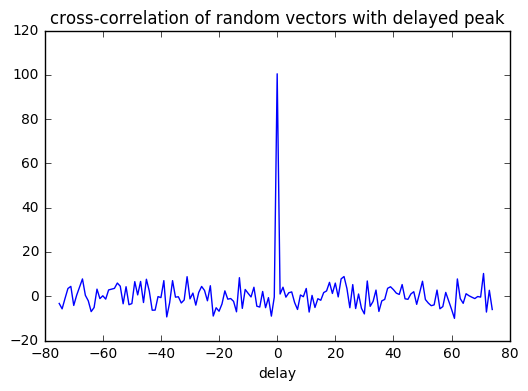

In [10]:
from ipywidgets import interact

def plot_cross_correlation(size=150):
    """Interactively plot cross-correlation of signals with delayed peak."""
    delays = list(range(-size//2,  size//2))
    a = [random.random()-0.5 for _ in range(size)]
    b = [random.random()-0.5 for _ in range(size)]
    
    a[size//2] = 10  # add peak in middle of vector
    
    def _plot(delay=0):
        b_ = b.copy()
        b_[size//2 + delay] = 10  # add peak at shifted position
        c = correlate_python(a, b_)
        
        pyplot.title("cross-correlation of random vectors with delayed peak")
        pyplot.xlabel("delay")
        pyplot.ylim([-20, 120])
        pyplot.plot(delays, c)        
        pyplot.show()

    interact(_plot, delay=(-size//2, size//2-1));
    
plot_cross_correlation()

Note that a positive delay of the peak in vector $b$ with respect to the peak in vector $a$ shows as a peak at a negative delay in the cross-correlation curve.

### Multi-threading

Let's try to use the Python [threading](https://docs.python.org/3/library/threading.html) module to **run several correlation functions in parallel on multiple CPU cores** within the same process.

Since threading.Thread does not return the results of the function calls we need to subclass it:

In [11]:
import threading

class ThreadWithReturn(threading.Thread):
    """Subclass of threading.Thread that returns function value."""

    def __init__(self, *args, **kwargs):
        threading.Thread.__init__(self, *args, **kwargs)
        self._result = None

    def run(self):
        function = self._target
        if function is not None:
            self._return = function(*self._args, **self._kwargs)

    def join(self):
        threading.Thread.join(self)
        return self._return


def map_threaded(function, iterable):
    """Apply function to every item of iterable and return list of results.
    
    This implementation starts one thread for each item of iterable. 
    In production better use a thread queue and a scheduler.
    
    """
    threads = [ThreadWithReturn(target=function, args=args) 
               for args in iterable]
    for thread in threads:
        thread.start()
    return [thread.join() for thread in threads]

In [12]:
a = [random.random()-0.5 for _ in range(2**13)]
b = [random.random()-0.5 for _ in range(2**13)]

%time c = map_threaded(correlate_python, [(a, b)] * 2)
assert c[0] == c[1]

Wall time: 11.6 s


There is **no improvement** over executing the functions sequentially.

In CPython, due to the Global Interpreter Lock (GIL), **only one thread can execute Python code at once**. 

Threading is still an appropriate model in Python if you want to run multiple I/O-bound tasks simultaneously. 

We'll see later that Python C extensions can release the GIL and be executed on multiple CPU cores using threads.

### Cross-correlation in C

Let's compare the performance of the Python function to an implementation in C.

The speed of compiled C code is often used as a reference when comparing single-threaded performance.

In [13]:
%%writefile correlate_c.c

/* A correlate function implemented in C */

#include <stddef.h>
#include <stdlib.h>
#include <stdio.h>

typedef ptrdiff_t ssize_t;

double dot(double *a, double *b, ssize_t start, ssize_t end, ssize_t delay) {
    double sum = 0.0;
    for (ssize_t n = start; n < end; n++)
        sum += a[n + delay] * b[n];
    return sum;
}


void correlate_c(double *a, double *b, double *c, ssize_t size) {
    ssize_t i = 0;
    ssize_t maxdelay = size / 2;
    for (ssize_t delay = -maxdelay; delay < 0; delay++)
        c[i++] = dot(a, b, -delay, size, delay);
    for (ssize_t delay = 0; delay < maxdelay; delay++)
        c[i++] = dot(a, b, 0, size-delay, delay);
}


void main() {
    ssize_t size = 8192;
    ssize_t loops = 50;
    
    double *a = (double*)malloc(size * sizeof(double));
    double *b = (double*)malloc(size * sizeof(double));
    for (ssize_t i = 0; i < size; i++) {
        a[i] = (double)rand()/(double)(RAND_MAX) - 0.5;
        b[i] = (double)rand()/(double)(RAND_MAX) - 0.5;
    }

    for (ssize_t i = 0; i < loops; i++) {
        double *c = (double*)malloc(size * sizeof(double));
        correlate_c(a, b, c, size);
        free(c);
    }
    
    free(a);
    free(b);
}

Overwriting correlate_c.c


We can use Python's [distutils.ccompiler](https://docs.python.org/3/distutils/apiref.html#module-distutils.ccompiler) module to compile and link the C code and use Jupyter's magick to time the generated executable:

In [14]:
from distutils import ccompiler

compiler = ccompiler.new_compiler()
objects = compiler.compile(['correlate_c.c'])
compiler.link_executable(objects, 'correlate_c')

In [15]:
import sys

if sys.platform == 'win32':
    t = %timeit -r 1 -q -o !correlate_c
else:
    t = %timeit -r 1 -q -o !./correlate_c

print ("%.2f ms per loop" % (t.best * 1000 / 50))

39.84 ms per loop


The C program calculates the correlation about **two orders of magnitudes faster than Python**.

### Python lists

So far we have used Python built-in list type to store sequences of floating point numbers.

Depending on the Python implementation and platform:

* Every item of a list is a 8 byte pointer to an object storing the value.

* Every floating point number is stored as a 24-byte object.

Hence Python lists are very inefficient for storing large number of homogeneous numerical data:

* the floating point numbers are **not stored contiguously** in a Python list.

* a Python list of floating point numbers is about **4x larger than a C array**:

In [16]:
import sys

array = [random.random() for _ in range(2**13)]

print("Storage size of Python list: %i bytes" % (
        sys.getsizeof(array) + sys.getsizeof(array[0]) * len(array)))

print("Storage size of C array:     %i bytes" % (
        8 + len(array) * 8))

Storage size of Python list: 265768 bytes
Storage size of C array:     65544 bytes


### Why CPython?

So far we have shown that:

* Python built-in lists cannot efficiently store homogeneous numerical data
* Python runs numerical code orders of magnitudes slower than compiled C
* Python code cannot be run in parallel on multiple CPU cores in the same process

Note that this applies to the CPython implementation only. Other Python implementations (pypy, Jython IronPython) might not have these limitations.

**Why are we considering CPython for the processing of big images**?

Some reasons are:

1. The **numpy library** provides a **standardized, efficient N-dimensional array object** to store homogeneous numerical data.

* A **large number of third party libraries** (numpy, scipy, scikit-image, etc.) provide fast implementations of numerical functions operating on numpy arrays.

* Python can be **extended using modules written in C**, which can release the GIL.

* Python code can be **type annotated and compiled to C code** using Cython.

* Python code can be **just in time compiled to LLVM, CUDA, or OpenCL** and executed on CPU or GPU, e.g. via numba or GT-Py

* Python can **interface with libraries** written in C, Fortran, R, Java, .NET, Matlab, etc.

* Many tasks are not CPU but **I/O bound**: waiting for data to load from the Internet, hard drive, or databases.

* Python can be used to **drive/control/schedule compile and compute tasks**.

* Python is great for **data munging**: mapping data from "raw" formats into more convenient formats.

### Cross-correlation in Numpy

Besides an efficient N-dimensional array object, the [numpy](http://www.numpy.org/) library provides useful, highly optimized functions operating on the arrays, including random number capabilities and a [correlate](http://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html) function.

Let's redefine the correlate and test functions using numpy:

In [17]:
import numpy

def correlate_numpy(a, b):
    """Retrun cross-correlation of two one-dimensional arrays."""
    return numpy.correlate(a, b, mode='same')


def test_correlate(correlate):
    """Test correlate function using known results."""
    c = correlate(numpy.array([1., 2., 3.]), 
                  numpy.array([4., 8., 16.]))
    assert numpy.allclose(c, [40., 68., 32.]), c
    
    c = correlate(numpy.array([1., 2., 3., 4.]), 
                  numpy.array([5., 6., 7., 8.]))
    assert numpy.allclose(c, [23.0, 44.0, 70.0, 56.0]), c

In [18]:
test_correlate(correlate_numpy)

a = numpy.random.random(2**13) - 0.5
b = numpy.random.random(2**13) - 0.5

%timeit correlate_numpy(a, b)

100 loops, best of 3: 11.1 ms per loop


Depending on how the numpy library was compiled, **numpy's correlate function is several times faster than our implementation in C**.

Numpy uses a highly optimized version of the dot product (from the BLAS library) for calculating the sliding dot product.

The storage size of the numpy array is close to a C array. The overhead of less than 100 bytes matters only for scalar values and small arrays:

In [19]:
print("Storage size of numpy array: %i bytes" % sys.getsizeof(a))

Storage size of numpy array: 65632 bytes


### Numpy multi-threaded

Many numpy functions release the GIL. However, some functions are highly optimized and make use of all available CPU cores, which can spoil running those functions in multiple threads:

In [20]:
%timeit map_threaded(correlate_numpy, [(a, b)] * 4)

10 loops, best of 3: 44.4 ms per loop


Depending on the numpy build options and CPU capabilities, running numpy functions in parallel threads might be much slower than running them sequentially.

### Using Numba to just-in-time compile Python code

The [numba](http://numba.pydata.org/) library can **generate optimized machine code from Python code** using the LLVM compiler infrastructure. No external C compiler is required.

In [21]:
import numpy
import numba

@numba.jit(nopython=True, nogil=True)
def dot(a, b, start, stop, delay):
    """Return the dot product of two sequences in range."""
    sum = 0.0
    for n in range(start, stop):
        sum += a[n + delay] * b[n]
    return sum


@numba.jit
def correlate_numba(a, b):
    """Retrun correlation of two one-dimensional sequences."""
    size = len(a)
    maxdelay = size // 2
    
    c = numpy.empty(size, 'float64')
    
    # negative shifts
    for delay in range(-maxdelay, 0):
        c[delay + maxdelay] = dot(a, b, -delay, size, delay)
    # positive shifts
    for delay in range(maxdelay + size % 2):
        c[delay + maxdelay] = dot(a, b, 0, size-delay, delay)

    return c

In [22]:
test_correlate(correlate_numba)

%timeit correlate_numba(a, b)
%timeit map_threaded(correlate_numba, [(a, b)] * 4)

10 loops, best of 3: 40.4 ms per loop
10 loops, best of 3: 167 ms per loop


Simply decorating the Python functions with `numba.jit` and using numpy array instead of lists gets you **speed comparable to C**. 

The `nogi=True` option does not seem to have any effect on this system. We could work around it by calling Python C API functions to release and restore the GIL via Python's built-in [ctypes](https://docs.python.org/3/library/ctypes.html) library (not shown; available on request).

### Cross-correlation in Cython

[Cython](http://cython.org/) is an optimizing static compiler for both the Python programming language and the extended Cython programming language. 

Cython makes writing C extensions for Python and interfacing with numpy arrays and C libraries easy. Unlike numba, Cython requires an external, Python compatible C compiler.

Cython integrates well with the Jupyter Notebook:

In [23]:
%load_ext Cython

Here we use Cython to implement the sliding dot product cross-correlation by

* **type annotating** the Python code.
* **releasing the GIL**.
* using **[typed memoryviews](http://cython.readthedocs.io/en/latest/src/userguide/memoryviews.html)** to access data in numpy arrays.
* **compiling the code to machine code** via Python C extension.

In [24]:
%%cython

# Cython implementation of the correlate function

#cython: boundscheck=False
#cython: wraparound=False

import numpy

cdef double dot(double[::1] a, double[::1] b, 
                ssize_t start, ssize_t end, ssize_t delay) nogil:
    cdef ssize_t n
    cdef double sum
    
    sum = 0.0
    for n in range(start, end):
        sum += a[n + delay] * b[n]
    return sum


def correlate_cython(double[::1] a not None, double[::1] b not None):
    cdef ssize_t size, delay, maxdelay
    
    size = a.size
    maxdelay = size / 2
    
    result = numpy.empty(size, dtype='float64')
    
    # we cannot access numpy array objects in a nogil section.
    # instead we use a Cython typed memoryview
    cdef double[::1] c = result
    
    with nogil:
        for delay in range(-maxdelay, 0):
            c[delay + maxdelay] = dot(a, b, -delay, size, delay)   
        for delay in range(maxdelay + size % 2):
            c[delay + maxdelay] = dot(a, b, 0, size-delay, delay)           
    
    return result

In [25]:
test_correlate(correlate_cython)

%timeit correlate_cython(a, b)
%timeit map_threaded(correlate_cython, [(a, b)] * 4)

10 loops, best of 3: 38.2 ms per loop
10 loops, best of 3: 40.4 ms per loop


The Cython implementation is **slightly faster than the C implementation**. Since the function releases the GIL, it can efficiently run in parallel on multiple CPU cores using multi-threading.

### Using Cython with OpenMP

[OpenMP](http://openmp.org/wp/) (Open Multi-Processing) is an application programming interface (API) that supports multi-platform **shared memory multiprocessing** programming in C, C++, and Fortran.

Cython's [`prange`](http://cython.readthedocs.io/en/latest/src/userguide/parallelism.html) function is implemented using OpenMP's "`#pragma omp parallel for`" directive.

We instruct the C compiler to use OpenMP by specifying extra compiler and linker arguments:

In [26]:
%%cython --compile-args=/openmp --link-args=-fopenmp

# with gcc use `--compile-args=-fopenmp`

#cython: boundscheck=False
#cython: wraparound=False

import numpy
from cython.parallel import prange, parallel


cdef double dot(double[::1] a, double[::1] b, 
                ssize_t start, ssize_t end, ssize_t delay) nogil:
    cdef ssize_t n
    cdef double sum
    
    sum = 0.0        
    for n in range(start, end):
        sum += a[n + delay] * b[n]        
    return sum


def correlate_cython_omp(double[::1] a not None, double[::1] b not None):
    cdef ssize_t size, delay, maxdelay
    
    size = a.size
    maxdelay = size / 2
    
    result = numpy.empty(size, dtype='float64')
    cdef double[::1] c = result
    
    with nogil, parallel():
        for delay in prange(-maxdelay, 0):
            c[delay + maxdelay] = dot(a, b, -delay, size, delay)   
        for delay in prange(maxdelay + size % 2):
            c[delay + maxdelay] = dot(a, b, 0, size-delay, delay)           
    
    return result

In [27]:
test_correlate(correlate_cython_omp)

%timeit correlate_cython_omp(a, b)
%timeit map_threaded(correlate_cython_omp, [(a, b)] * 4)

100 loops, best of 3: 4.64 ms per loop
100 loops, best of 3: 20.2 ms per loop


Depending on the number of CPU cores, this function is several times faster than the previous implementation, but it can no longer be efficiently multi-threaded.

### Cross-correlation using Scipy's convolution function

The [scipy](https://www.scipy.org/) library provides many efficient numerical routines such as numerical integration and optimization.

The [`scipy.signal.fftconvolve`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html) function uses zero-padding and the **Fast Fourier Transform (FFT)** according to the convolution theorem to calculate the convolution of two vectors. 

Recall that the cross-correlation of functions $a(t)$ and $b(t)$ is equivalent to the **convolution** ($*$) of $a(t)$ and $b^*(-t)$:

$$ a\star b = a*b^*(-t),$$

It means that **correlation can be calculated using convolution by reversing the second input vector**:

In [28]:
import scipy.signal

def correlate_scipy(a, b):
    """Return circular correlation of two vectors."""
    return scipy.signal.fftconvolve(a, b[::-1], 'same')

In [29]:
test_correlate(correlate_scipy)

%timeit correlate_scipy(a, b)
%timeit map_threaded(correlate_scipy, [(a, b)] * 4)

1000 loops, best of 3: 681 µs per loop
100 loops, best of 3: 2.23 ms per loop


This is about an order of magnitude faster and scales much better with the vector sizes than the multi-threaded Cython implementation of the sliding dot product.

### Circular correlation using FFT

Let's implement a circular correlation function using numpy's FFT functions according to the **cross-correlation theorem**:

$$ a\star b = \mathcal{F}^{-1}(\mathcal{F}\{a\} \cdot (\mathcal{F}\{b\})^*)$$

In [30]:
from numpy.fft import rfft, irfft, fftshift

def correlate_fft(a, b):
    """Return circular correlation of two vectors."""
    # forward DFT
    a = rfft(a)
    b = rfft(b)
    # multiply by complex conjugate
    a *= b.conj()
    # reverse DFT
    c = irfft(a)
    # shift
    c = fftshift(c)
    return c

In [31]:
%timeit correlate_fft(a, b)
%timeit map_threaded(correlate_fft, [(a, b)] * 4)

1000 loops, best of 3: 298 µs per loop
1000 loops, best of 3: 1.37 ms per loop


Recall that the **circular correlation function can calculate the linear correlation by zero-padding the vectors** (to twice the size for even length vectors):

In [32]:
c = correlate_fft(numpy.pad(a, a.size//2, mode='constant'), 
                  numpy.pad(b, b.size//2, mode='constant'))

assert numpy.allclose(c[a.size//2: -a.size//2], 
                      correlate_numpy(a, b))

In general, circular correlation should only be used to analyze cyclic functions. However, we can demonstrate that for our specific application the results obtained from circular correlation do not significantly differ from linear correlation (not show; available on request). Hence we will continue using the faster circular correlation.

### Using Cython with a FFT C library

The [fft2d C library](http://www.kurims.kyoto-u.ac.jp/~ooura/fft.html) by Takuya Ooura provides efficient functions to compute Fast Fourier Transforms (FFT).

Cython makes it relatively easy to use C libraries from Python.

The file **`fftsg.c` defines a function `rdft`**, which we will use to compute forward and invers DFT of real input vectors: 

```
Fast Fourier/Cosine/Sine Transform
    dimension   :one
    data length :power of 2
    decimation  :frequency
    radix       :split-radix
    data        :inplace
    table       :use

functions
    rdft: Real Discrete Fourier Transform
    
function prototypes
    void rdft(int, int, double *, int *, double *);

-------- Real DFT / Inverse of Real DFT --------
    [definition]
        <case1> RDFT
            R[k] = sum_j=0^n-1 a[j]*cos(2*pi*j*k/n), 0<=k<=n/2
            I[k] = sum_j=0^n-1 a[j]*sin(2*pi*j*k/n), 0<k<n/2
        <case2> IRDFT (excluding scale)
            a[k] = (R[0] + R[n/2]*cos(pi*k))/2 + 
                   sum_j=1^n/2-1 R[j]*cos(2*pi*j*k/n) + 
                   sum_j=1^n/2-1 I[j]*sin(2*pi*j*k/n), 0<=k<n
    [usage]
        <case1>
            ip[0] = 0; // first time only
            rdft(n, 1, a, ip, w);
        <case2>
            ip[0] = 0; // first time only
            rdft(n, -1, a, ip, w);
    [parameters]
        n              :data length (int)
                        n >= 2, n = power of 2
        a[0...n-1]     :input/output data (double *)
                        <case1>
                            output data
                                a[2*k] = R[k], 0<=k<n/2
                                a[2*k+1] = I[k], 0<k<n/2
                                a[1] = R[n/2]
                        <case2>
                            input data
                                a[2*j] = R[j], 0<=j<n/2
                                a[2*j+1] = I[j], 0<j<n/2
                                a[1] = R[n/2]
        ip[0...*]      :work area for bit reversal (int *)
                        length of ip >= 2+sqrt(n/2)
                        strictly, 
                        length of ip >= 
                            2+(1<<(int)(log(n/2+0.5)/log(2))/2).
                        ip[0],ip[1] are pointers of the cos/sin table.
        w[0...n/2-1]   :cos/sin table (double *)
                        w[],ip[] are initialized if ip[0] == 0.
    [remark]
        Inverse of 
            rdft(n, 1, a, ip, w);
        is 
            rdft(n, -1, a, ip, w);
            for (j = 0; j <= n - 1; j++) {
                a[j] *= 2.0 / n;
            }
```

We can use Python's distutils module to compile the `fftsg.c` C code into a static link library:

In [33]:
from distutils import ccompiler

compiler = ccompiler.new_compiler()
objects = compiler.compile(['fft2d/fftsg.c'], extra_postargs=['-fPIC'])
compiler.create_static_lib(objects, 'ftt2d', output_dir='.')

To use the `ftt2d` library from Cython we need to include the declaration from the C header file and also allocate temporary arrays:

In [34]:
%%cython -I. -l./ftt2d

# Cython implementation of a circular correlation function using fft2d C library

#cython: boundscheck=False
#cython: wraparound=False

import numpy

from cpython.mem cimport PyMem_Malloc, PyMem_Free
from libc.math cimport sqrt


cdef extern from "fft2d.h":
    void rdft(int n, int isgn, double *a, int *ip, double *w) nogil

        
def correlate_fft_cython(double[:] a not None, double[:] b not None):
    """Return circular correlation of two sequences."""
    cdef ssize_t size = a.size
    
    # copy input arrays. rdft computes inplace
    result = numpy.copy(a)
    cdef double[::1] a_ = result
    cdef double[::1] b_ = numpy.copy(b)
    
    # allocate cos/sin table
    cdef double *w_ = <double *>PyMem_Malloc(size // 2 * sizeof(double))
    if not w_:
        raise MemoryError("could not allocate w_")
        
    # allocate work area for bit reversal
    cdef int s = 2 + <int>(sqrt((size // 2) + 0.5))
    cdef int *ip_ = <int *>PyMem_Malloc(s * sizeof(int))
    if not ip_:
        raise MemoryError("could not allocate ip_")
    ip_[0] = 0
    
    with nogil:
        # forward DFT
        rdft(size, 1, &b_[0], ip_, w_)
        rdft(size, 1, &a_[0], ip_, w_)

        # multiply by complex conjugate
        multiply_conj(a_, b_, size)

        # reverse DFT
        rdft(size, -1, &a_[0], ip_, w_)

        # shift and scale results
        fftshift(a_, size, 2.0 / size)
    
    PyMem_Free(w_)
    PyMem_Free(ip_)
    
    return result


cdef inline void multiply_conj(double[::1] a, double[::1] b, 
                               ssize_t size) nogil:
    """Inplace multiply `a` by complex conjugate of `b`."""
    cdef ssize_t i
    cdef double ar, br, ai, bi
    
    a[0] = a[0] * b[0]
    a[1] = a[1] * b[1]
    for i in range(2, size, 2):
        ar = a[i]
        ai = a[i+1]
        br = b[i]
        bi = b[i+1]
        a[i] = ar * br + ai * bi
        a[i+1] = ai * br - ar * bi


cdef inline void fftshift(double[::1] a, ssize_t size, double scale) nogil:
    """Inplace shift zero-frequency component to center of spectrum."""
    cdef ssize_t size2 = size / 2
    cdef ssize_t i
    cdef double t
    
    for i in range(size2):
        t = a[i]
        a[i] = a[i + size2] * scale
        a[i + size2] = t * scale

In [35]:
assert numpy.allclose(correlate_fft(a, b), 
                      correlate_fft_cython(a, b))

%timeit correlate_fft_cython(a, b)
%timeit map_threaded(correlate_fft_cython, [(a, b)] * 4)

10000 loops, best of 3: 160 µs per loop
1000 loops, best of 3: 895 µs per loop


So far this is the fastest implementation of the correlate function. It can be run multi-threaded, although for short input vectors the overhead of multi-threading is significant.

### Compare implementations

Finally, we compare several implementations of the cross-correlate function using longer time series of 16384 samples:

In [84]:
import timeit
from multiprocessing import cpu_count
from ipywidgets import IntProgress
from IPython.display import display


def time_functions(functions, size=2**14, num_threads=cpu_count()//2):
    """Return runtimes of single and multi-threaded correlation functions."""
    progress = IntProgress(min=0, max=2*len(functions))
    display(progress)

    a = numpy.random.random(size) - 0.5
    b = numpy.random.random(size) - 0.5
    ab = [(a, b)] * num_threads
    
    result = []
    for function in functions:
        func = globals()[function]
        t0 = timeit.Timer(lambda: func(a, b)).timeit(number=1)
        number = max(2, int(1 / t0))
        t0 = timeit.Timer(lambda: func(a, b)).timeit(number=number)
        progress.value += 1
        t1 = timeit.Timer(lambda: map_threaded(func, ab)).timeit(number=number)
        progress.value += 1
        result.append(['%.3f' % (t0 * 1e3 / number),
                       '%.3f' % (t1 * 1e3 / number / num_threads)])
    progress.close()
    try:
        import pandas
        columns = ['1 thread / ms', '%i threads / ms' % num_threads]
        return pandas.DataFrame(result, index=functions, columns=columns)
    except ImportError:
        return result


display(time_functions(['correlate_numpy', 
                        'correlate_numba',
                        'correlate_cython',
                        'correlate_cython_omp',
                        'correlate_scipy',
                        'correlate_fft',
                        'correlate_fft_cython']))

1 thread / ms 6 threads / ms
correlate_numpy             45.536         45.322
correlate_numba            162.356        163.870
correlate_cython           157.368         26.952
correlate_cython_omp        20.087         17.210
correlate_scipy              1.597          0.688
correlate_fft                0.642          0.350
correlate_fft_cython         0.347          0.234

The best implementation of the correlate function is **still not as fast as desired (~200 µs)** for the pair correlation analysis of images.

The correlate function could be further optimized by implementing it in C++ and using the DFTi functions of the closed source [Intel MKL](https://software.intel.com/en-us/intel-mkl) library. Expect a 30% speed improvement.

---
## 2. Implement pair correlation analysis of small image time series

Now that we have developed a fast cross-correlation function and learned techniques to speed-up Python code, we use them to analyze a small simulated time series of images.

### Load and explore simulated images

The **`Simulation_Channel.bin`** file contains the result of a simulation of fluorescent particles diffusing on a **64x64 grid**. The grid contains a **diagonal, 300 nm wide channel**, which restricts free diffusion. The file was produced using the  [Globals for Images · SimFCS](http://www.lfd.uci.edu/globals/) software.

The simulated images at **32000 time steps** are stored contiguously as **16 bit unsigned integers** in the file. 

The time samples are not stored contiguously. Accessing time series will be inefficient while spatial access will be fast:

![time_vs_spatial_access](time_vs_spatial_access.png)

We can use the [`numpy.fromfile`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.fromfile.html) function to load the data into a 3D numpy array:

In [37]:
import numpy

def rawread(filename, shape, dtype):
    """Return array data from binary file."""
    count = numpy.prod(shape, dtype='intp')
    count = count if count >= 0 else -1
    data = numpy.fromfile(filename, dtype=dtype, count=count)
    data.shape = shape
    return data

In [38]:
simulated_data = rawread('Simulation_Channel.bin',                          
                         shape=(-1, 64, 64),
                         dtype='uint16')

print("Data shape:", simulated_data.shape)

Data shape: (32000, 64, 64)


In order for FFTs to be performed efficiently, the **size of the time axis is truncated to a power of two**:

In [39]:
import math

def shape2pow2(data, axis):
    """Return array with axis truncated to power of 2."""
    try:
        iter(axis)
    except TypeError:
        axis = [axis]
    slices = []
    for i, size in enumerate(data.shape):
        if i in axis:
            size = 2**int(math.log(size, 2))
        slices.append(slice(0, size))
    return data[slices]

In [40]:
simulated_data = shape2pow2(simulated_data, axis=0)

print("Truncated shape:", simulated_data.shape)

Truncated shape: (16384, 64, 64)


Let's plot the averages over the time axis (mean image) and the spatial axes (mean time series):

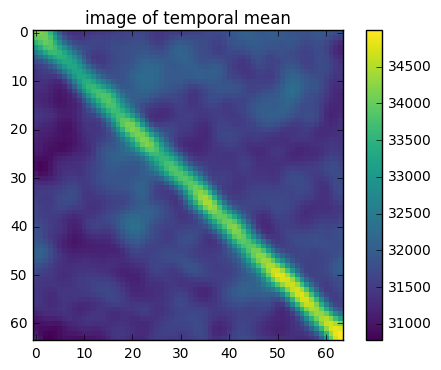

In [41]:
%matplotlib inline

from matplotlib import pyplot

mean_image = numpy.mean(simulated_data, axis=0)
pyplot.title("image of temporal mean")
pyplot.imshow(mean_image, interpolation='none', cmap='viridis')
pyplot.colorbar()
pyplot.show()

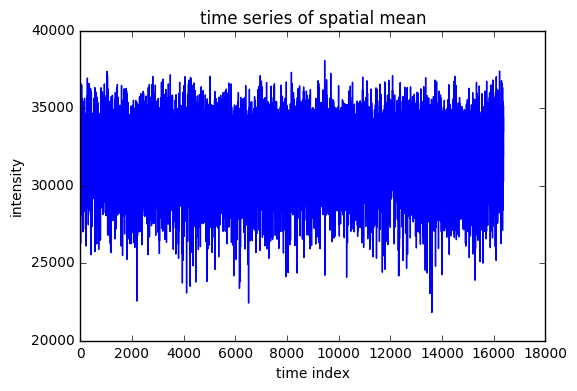

In [42]:
mean_ts = numpy.mean(simulated_data, axis=(1, 2))
pyplot.title("time series of spatial mean")
pyplot.xlabel('time index')
pyplot.ylabel('intensity')
pyplot.plot(mean_ts)
pyplot.show()

### Process cross-correlation functions for image fluctuation analysis

In image fluctuation correlation spectroscopy, the cross correlation functions are regularly processed and presented as follows:

1. Only the **positive time delays** are used. This actually corresponds to the negative delays for the definition of cross-correlation we used.

2. The correlation functions are **normalized by the product of the means of the two time series** and **subtracted `1`**.
   Alternatively, the means of the time series could be subtracted from the signals before the correlation is computed.

3. The functions are **averaged in exponentially increasing bins of delays**.

4. The log-binned functions are **smoothed**.

We define the following functions for fluctuation correlation analysis of time series:

In [43]:
def correlate(a, b):
    """Return circular correlation using DFT."""
    size = a.size
    # forward DFT
    a = numpy.fft.rfft(a)
    b = numpy.fft.rfft(b)
    # multiply by complex conjugate
    c = a.conj() * b
    # reverse DFT
    c = numpy.fft.irfft(c)    
    # positive delays only
    c = c[:size // 2]
    # normalize with the averages of a and b
    #   c is already normalized by size
    #   the 0th value of the DFT contains the sum of the signal
    c /= a[0].real * b[0].real / size
    c -= 1.0
    return c

        
def logbins(size, nbins):
    """Return up to nbins exponentially increasing integers from 1 to size."""
    b = numpy.logspace(0, math.log(size, 2), nbins, base=2, endpoint=True)
    return numpy.unique(b.astype('intp'))


def average(c, bins):
    """Return averaged chunks of vector."""
    out = [numpy.mean(c[:bins[0]])]
    for i in range(len(bins)-1):
        out.append(numpy.mean(c[bins[i]:bins[i+1]]))
    return out


def smooth(c):
    """Return double exponentially smoothed vector."""
    out = c.copy()
    out[0] = out[1]
    for i in range(1, len(out)):
        out[i] = out[i] * 0.3 + out[i-1] * 0.7
    for i in range(len(out)-2, -1, -1):
        out[i] = out[i] * 0.3 + out[i+1] * 0.7
    return out

Let's plot two time series, their normalized cross-correlation function, the log-binned function, and the final **smoothed log-binned normalized cross-correlation function**.

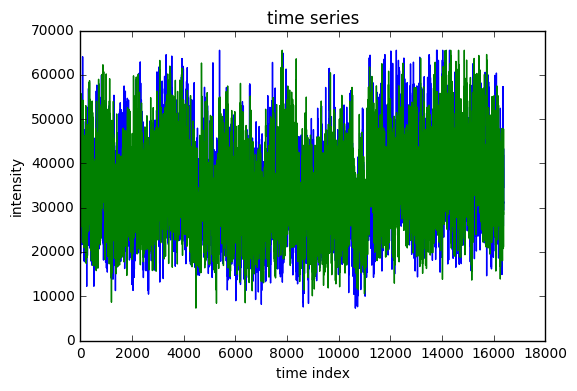

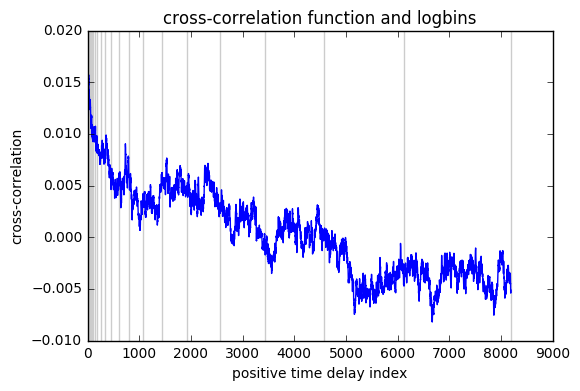

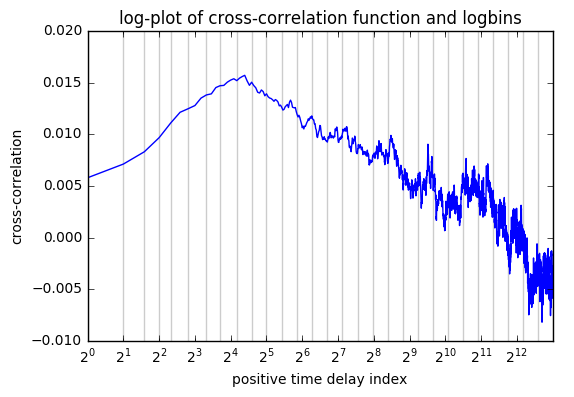

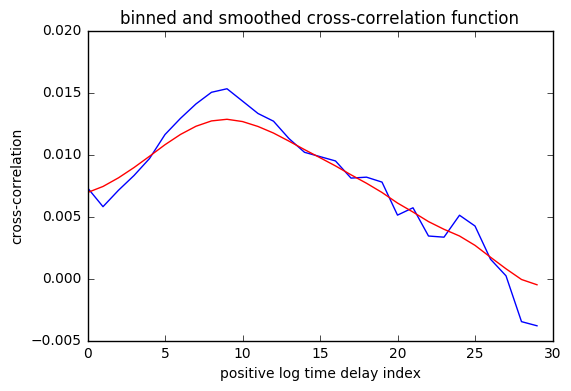

In [44]:
# select two time series from the simulated data
a = simulated_data[:, 31, 31]
b = simulated_data[:, 35, 35]

# correlate, log-bin, and smooth
c = correlate(a, b)
bins = logbins(c.size, 32)
averaged = average(c, bins)
smoothed = smooth(averaged)

# plot the time series
pyplot.title("time series")
pyplot.xlabel('time index')
pyplot.ylabel('intensity')
pyplot.plot(a)
pyplot.plot(b)
pyplot.show()

# plot the cross-correlation function and logbins
pyplot.title("cross-correlation function and logbins")
pyplot.xlabel('positive time delay index')
pyplot.ylabel('cross-correlation')
for x in bins:
    pyplot.axvline(x=x, color='0.8')
pyplot.plot(c)
pyplot.show()

# log-plot the cross-correlation function and logbins
pyplot.title("log-plot of cross-correlation function and logbins")
pyplot.xlabel('positive time delay index')
pyplot.ylabel('cross-correlation')
for x in bins:
    pyplot.axvline(x=x, color='0.8')
pyplot.semilogx(c, basex=2)
pyplot.show()

# plot the binned and smoothed cross-correlation function
pyplot.title("binned and smoothed cross-correlation function")
pyplot.xlabel('positive log time delay index')
pyplot.ylabel('cross-correlation')
pyplot.plot(averaged, 'b')
pyplot.plot(smoothed, 'r')
pyplot.show()

### Reference implementation of pair correlation image analysis

We are ready to implement and run the pair correlation analysis on small images.

For the reference implementation of the `ipcf` function will use the previously defined pseudo code and the correlate function using numpy.fft:

In [45]:
import math
import numpy
from numpy import zeros

def ipcf_reference(image_timeseries, circle_coordinates, bins):
    """Return pair correlation analysis of an image time series.
    
    Cross-correlate the time series of each pixel of the image 
    with all its neighbors at a certain radius and return all 
    the smoothed and log-binned correlation curves.
    
    """
    ntimes, height, width = image_timeseries.shape
    npoints = len(circle_coordinates)
    radius = circle_coordinates[0, 0]
    
    result = zeros((height-2*radius, width-2*radius, npoints, len(bins)), 
                   'float32')
    
    for y in range(radius, height-radius):
        for x in range(radius, width-radius):
            a = image_timeseries[:, y, x]
            for i in range(npoints):
                u, v = circle_coordinates[i]
                b = image_timeseries[:, y+v, x+u]
                c = correlate(b, a)
                result[y-radius, x-radius, i] = smooth(average(c, bins))

    return result


def correlate(a, b):
    """Return circular correlation using DFT."""
    size = a.size
    # forward DFT
    a = numpy.fft.rfft(a)
    b = numpy.fft.rfft(b)
    # multiply by complex conjugate
    c = a * b.conj()
    # reverse DFT
    c = numpy.fft.irfft(c)    
    # positive delays only
    c = c[:size // 2]
    # normalize with the averages of a and b
    #   c is already normalized by size
    #   the 0th value of the DFT contains the sum of the signal
    c /= a[0].real * b[0].real / size
    c -= 1.0
    return c


def logbins(size, nbins):
    """Return up to nbins exponentially increasing integers from 1 to size."""
    b = numpy.logspace(0, math.log(size, 2), nbins, base=2, endpoint=True)
    return numpy.unique(b.astype('intp'))


def average(c, bins):
    """Return averaged chunks of vector."""
    out = [numpy.mean(c[:bins[0]])]
    for i in range(len(bins)-1):
        out.append(numpy.mean(c[bins[i]:bins[i+1]]))
    return out


def smooth(c):
    """Return double exponentially smoothed vector."""
    out = c.copy()
    out[0] = out[1]
    for i in range(1, len(out)):
        out[i] = out[i] * 0.3 + out[i-1] * 0.7
    for i in range(len(out)-2, -1, -1):
        out[i] = out[i] * 0.3 + out[i+1] * 0.7
    return out


def circle(radius, npoints):
    """Return cartesian coordinates of circle on integer grid."""
    angles = numpy.linspace(0, 2*numpy.pi, npoints, endpoint=False)
    coordinates = radius * numpy.array((numpy.cos(angles), numpy.sin(angles)))
    return numpy.ascontiguousarray(numpy.round(coordinates).T.astype('intp'))

Now that all functions are defined, we can analyze the simulated data and compare it to the know results:

In [46]:
def run_ipcf(ipcf_function, image_timeseries, 
             radius=6, npoints=32, nbins=32):
    """Run ipcf_function on image_timeseries."""
    ntimes, height, width = image_timeseries.shape
   
    # truncate time axis to power of two
    ntimes = 2**int(math.log(ntimes, 2))
    image_timeseries = image_timeseries[:ntimes]
    
    # calculate circle coordinates
    circle_coordinates = circle(radius, npoints)
    
    # calculate log-bins
    bins = logbins(ntimes // 2, nbins)
  
    # run the paired correlation analysis
    result = ipcf_function(image_timeseries, circle_coordinates, bins)
    
    return result


def test_ipcf(result, filename='Simulation_Channel.ipcf.bin', 
              shape=(52, 52, 32, 30), dtype='float32', atol=1e-6):
    """Compare ipcf result to known results from file."""
    expected = numpy.fromfile(filename, dtype=dtype)
    expected.shape = shape
    if not numpy.allclose(result, expected, atol=atol):
        try:
            plot_ipcf_results(result - expected)
        except NameError:
            print("Test failed")

We expect the paired correlation analysis of the small simulated images to finish in about two minutes:

In [47]:
%time ipcf_result = run_ipcf(ipcf_reference, simulated_data)
test_ipcf(ipcf_result)

Wall time: 2min 2s


### Plot image pair correlation functions

Using [IPython widgets](https://ipywidgets.readthedocs.io/en/latest/) we can interactively select a pixel and plot the calculated log-binned and smoothed cross-correlations with its circular neighbors (**sprites**):

In [48]:
%matplotlib inline

from matplotlib import pyplot
from ipywidgets import interact


def plot_ipcf_sprites(data, cmap='seismic'):
    """Interactively plot ipcf results as sprites."""
    height, width, npoints, nbins = data.shape

    # data limits
    vmax, vmin = numpy.max(data), numpy.min(data)
    vminmax = max(abs(vmax), abs(vmin))

    # coordinates for polar plot and Delaunay triangulation
    radius = numpy.arange(nbins)
    angles = numpy.linspace(0, 2*numpy.pi, npoints, endpoint=False)
    radius, angles = numpy.meshgrid(radius, angles)
    xcoords = radius * numpy.cos(angles)
    ycoords = radius * numpy.sin(-angles)

    def _plot(style, y, x):
        # plot pair correlation functions at pixel y, x using style
        pyplot.title("pair correlation curves at pixel")
        sprite = data[y, x]
        if style == 'lines':
            pyplot.plot(sprite.T, 'b')
            pyplot.ylim([vmin, vmax])
            pyplot.xlabel('log time delay index')
            pyplot.ylabel('pcf')       
        elif style == 'carpet':
            pyplot.imshow(sprite, vmin=-vminmax, vmax=vminmax, cmap=cmap)
            pyplot.xlabel('log time delay index')
            pyplot.ylabel('neighbor index')
            pyplot.colorbar()
        elif style == 'polar':
            # polar plot using Delaunay triangulation
            pyplot.tripcolor(xcoords.flat, ycoords.flat, sprite.flat, 
                             vmin=-vminmax, vmax=vminmax,
                             shading='gouraud', cmap=cmap)
            pyplot.axes().set_aspect('equal')
            pyplot.axis('off')
            pyplot.colorbar()
        pyplot.show()

    interact(_plot, 
             style=['carpet', 'polar', 'lines'],
             y=(0, height-1), x=(0, width-1));

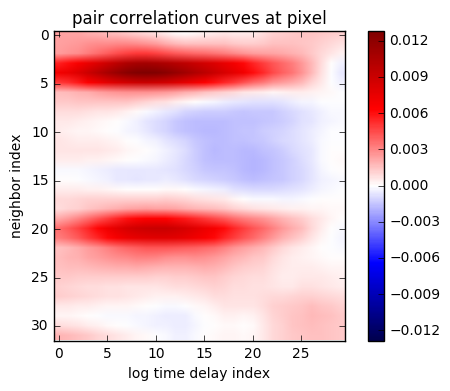

In [49]:
plot_ipcf_sprites(ipcf_result)

We can also plot the values of the cross correlation curves at a specified point and bin as images:

In [50]:
def plot_ipcf_images(data, figsize=None, cmap='seismic'):
    """Interactively plot ipcf results as images."""
    height, width, npoints, nbins = data.shape
    transpose = height > 1.5 * width

    # data limits
    vmax, vmin = numpy.max(data), numpy.min(data)
    vminmax = max(abs(vmax), abs(vmin))

    def _plot(point, bin):
        # plot image of pair correlation function values
        if figsize:
            pyplot.figure(figsize=figsize)
        image = data[:, :, point, bin]
        if transpose:
            image = image.T
        pyplot.title("image of pair correlation values")
        pyplot.imshow(image, vmin=-vminmax, vmax=vminmax, cmap=cmap)
        pyplot.colorbar(orientation='horizontal' if transpose else 'vertical')
        pyplot.show()

    interact(_plot, point=(0, npoints-1), bin=(0, nbins-1));

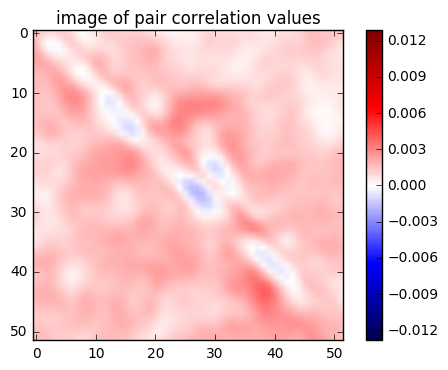

In [51]:
plot_ipcf_images(ipcf_result)

###  Optimizing the ipcf function

The algorithm and implementation of the image pair correlation function can be improved by the following means:

1. change the data layout such that the **time axis becomes contiguous** and the individual time series can be accessed much faster.

* **pre calculate the forward DFT** and use it for cross correlation instead of the data. For our dataset this will take 512 MB RAM.

* redefine functions to **not allocate new arrays on every function call** but to write directly to the output array.

* use the **symmetry of the cross-correlation function** `correlate(a, b) == correlate(b, a)[::-1]` to avoid duplicate calculations.

* **JIT compile** the functions using numba.

In [52]:
import numpy
import numba

@numba.jit
def ipcf_optimized(image_timeseries, circle_coordinates, bins):
    """Return pair correlation analysis of an image time series.
    
    Cross-correlate the time series of each pixel of the image 
    with all its neighbors at a certain radius and return all 
    the smoothed and log-binned correlation curves.
    
    """
    ntimes, height, width = image_timeseries.shape
    npoints = len(circle_coordinates)
    radius = circle_coordinates[0, 0]
    
    result = numpy.zeros((height-2*radius, width-2*radius, npoints, len(bins)), 'float32')
    
    # make time axis C contiguous
    data = numpy.moveaxis(image_timeseries, 0, -1)
    
    # pre calculate forward DFT along time axis
    rfft = numpy.fft.rfft(data, axis=-1)
    
    for y in range(radius, height-radius):
        for x in range(radius, width-radius):

            rfft_a = rfft[y, x].conj()
            
            for i in range(npoints):
               
                # continue if output was already calculated
                if result[y-radius, x-radius, i, 0] != 0.0:
                    continue
                    
                u, v = circle_coordinates[i]                
                rfft_b = rfft[y+v, x+u]
                
                # cross correlate a and b
                c = numpy.fft.irfft(rfft_a * rfft_b)
                
                scale = ntimes / rfft_a[0].real / rfft_b[0].real
                
                # positive delays                
                average_smooth(c, bins, scale,
                               result[y-radius, x-radius, i])

                # negative delays
                if (radius <= y+v < height-radius and 
                    radius <= x+u < width-radius):
                    c = numpy.fft.fftshift(c)
                    i = (i + npoints // 2) % npoints
                    average_smooth(c[ntimes//2:0:-1], bins, scale,
                                   result[y+v-radius, x+u-radius, i])

    return result


@numba.jit()
def average_smooth(c, bins, scale, out):
    """Average, scale, and smooth chunks of vector."""
    # average
    out[0] = numpy.mean(c[:bins[0]])
    for i in range(len(bins)-1):
        out[i+1] = numpy.mean(c[bins[i]:bins[i+1]])
        
    # smooth
    out[0] = out[1]
    for i in range(1, len(bins)):
        out[i] = out[i] * 0.3 + out[i-1] * 0.7
    for i in range(len(bins)-2, -1, -1):
        out[i] = out[i] * 0.3 + out[i+1] * 0.7

    # scale
    out *= scale
    out -= 1.0

In [53]:
%time ipcf_result = run_ipcf(ipcf_optimized, simulated_data)
test_ipcf(ipcf_result)

Wall time: 22.2 s


### A fast ipcf function in Cython

Now that we have optimized the algorithm of the pair correlation analysis of images, we implement the function in Cython using [OpenMP]() and the [fft2d C library](http://www.kurims.kyoto-u.ac.jp/~ooura/fft.html).

First we use Python's distutils module to compile the `fftsg.c` C code into a static link library:

In [54]:
from distutils import ccompiler

compiler = ccompiler.new_compiler()
objects = compiler.compile(['fft2d/fftsg.c'], extra_postargs=['-fPIC'])
compiler.create_static_lib(objects, 'ftt2d', output_dir='.')

Next we define the ipcf function in Cython and compile and link it to the ftt2d and OpenMP libraries:

In [55]:
%reload_ext Cython

In [56]:
%%cython -I. -l./ftt2d --compile-args=/openmp --link-args=-fopenmp

# with gcc use `--compile-args=-fopenmp`

#cython: boundscheck=False
#cython: wraparound=False
#cython: cdivision=True

import math
import numpy
from cython.parallel import prange, parallel

cimport numpy
from libc.stdlib cimport malloc, free
from libc.math cimport sqrt

cdef extern from "fft2d.h":
    void rdft(int n, int isgn, double *a, int *ip, double *w) nogil


def ipcf_cython(numpy.uint16_t [:, :, :] image_timeseries not None,
                ssize_t [:, ::1] circle_coordinates not None,
                ssize_t [::1] bins not None,
                int num_threads=0):
    """Return pair correlation analysis of an image time series.
    
    Cross-correlate the time series at each pixel of the image 
    with all its neighbors at a certain radius and return
    the log-binned and smoothed correlation curves at each pixel
    (excluding the image border).
    
    """
    cdef ssize_t ntimes = image_timeseries.shape[0]
    cdef ssize_t height = image_timeseries.shape[1]
    cdef ssize_t width = image_timeseries.shape[2]
    cdef ssize_t nbins = bins.shape[0]
    cdef ssize_t npoints = circle_coordinates.shape[0]
    cdef ssize_t radius = circle_coordinates[0, 0]
    
    # limit length of time axis to power of two
    ntimes = 2**int(math.log(ntimes, 2))

    if radius < 2:
        raise ValueError("invalid radius")
    if width <= 2*radius or height <= 2*radius:
        raise ValueError("invalid image size")
    if ntimes < 32 or ntimes > 2147483647:
        raise ValueError("invalid size of time axis")
        
    # output array
    result = numpy.zeros((height-2*radius, width-2*radius, npoints, nbins), 
                         dtype='float32')
    cdef float[:, :, :, ::1] out = result

    # buffer for forward DFT
    cdef double [:, :, ::1] rdft_ = numpy.empty((height, width, ntimes), 
                                                dtype='float64')
    
    # rdft cos/sin table
    cdef double *w_ = <double *>malloc(ntimes // 2 * sizeof(double))
    if not w_:
        raise MemoryError("could not allocate w_")

    # rdft work area for bit reversal
    cdef int s = 2 + <int>(sqrt((ntimes // 2) + 0.5))
    cdef int *ip_ = <int *>malloc(s * sizeof(int))
    if not ip_:
        raise MemoryError("could not allocate ip_")

    # initialize ip_ and w_
    ip_[0] = 0
    rdft(ntimes, 1, &rdft_[0, 0, 0], ip_, w_)

    cdef ssize_t x, y, u, v, i, t, x1, y1, t1
    cdef double *a_
    cdef double *rfft_a
    cdef double *rfft_b
    cdef double scale

    with nogil, parallel(num_threads=num_threads):
        # thread-local input/output data
        a_ = <double *>malloc(sizeof(double) * ntimes)
        if not a_:
            with gil:
                raise MemoryError("could not allocate a_")
        
        # forward DFT
        for y1 in prange(height):
            for x1 in range(width):
                for t1 in range(ntimes):
                    rdft_[y1, x1, t1] = <double>image_timeseries[t1, y1, x1]
                rdft(ntimes, 1, &rdft_[y1, x1, 0], ip_, w_)

        # cross correlation
        for y in prange(radius, height-radius):
            for x in range(radius, width-radius):
                rfft_a = &rdft_[y, x, 0]
                
                for i in range(npoints):
                    # continue if output was already calculated
                    if out[y-radius, x-radius, i, 0] != 0.0:
                        continue
                        
                    u = x + circle_coordinates[i, 0]
                    v = y + circle_coordinates[i, 1]                   
                    
                    rfft_b = &rdft_[v, u, 0]
                    
                    # multiply b's DFT by complex conjugate of a's DFT
                    multiply_conj(rfft_b, rfft_a, a_, ntimes)

                    # invers DFT
                    rdft(ntimes, -1, a_, ip_, w_)
                    
                    scale = 2.0 / (rfft_a[0] * rfft_b[0])
                      
                    # positive delays
                    average_smooth(a_, ntimes, bins, nbins, scale, 
                                   out[y-radius, x-radius, i])
                    
                    # negative delays
                    if ((v >= radius) and (v < height-radius) and 
                        (u >= radius) and (u < width-radius)):
                        i = (i + npoints // 2) % npoints
                        average_smooth(a_, ntimes, bins, nbins, scale, 
                                       out[v-radius, u-radius, i], -1)
        free(a_)

    free(w_)
    free(ip_)
    return result


cdef inline void multiply_conj(
    double *a, 
    double *b, 
    double *c, 
    ssize_t size) nogil:
    """Multiply `a` by complex conjugate of `b` and store in `c`."""
    cdef ssize_t i
    cdef double ar, br, ai, bi
    
    c[0] = a[0] * b[0]
    c[1] = a[1] * b[1]
    for i in range(2, size, 2):
        ar = a[i]
        ai = a[i+1]
        br = b[i]
        bi = b[i+1]
        c[i] = ar * br + ai * bi
        c[i+1] = ai * br - ar * bi
    
        
cdef inline void average_smooth(
    double *a,
    ssize_t size,
    ssize_t[::1] bins,
    ssize_t nbins,
    double scale,
    float[::1] out,
    int mode=1) nogil:
    """Average vector in bins and smooth results.
    
    The first nbins items of the input vector are changed.
    
    """
    cdef ssize_t i, j
    cdef double s

    # average
    if mode == 1:
        # positive delays
        s = 0.0
        for i in range(bins[0]):
            s += a[i]
        a[0] = s / <double>bins[0]

        for j in range(1, nbins):
            s = 0.0
            for i in range(bins[j-1], bins[j]):
                s += a[i]
            a[j] = s / <double>(bins[j] - bins[j-1])
    else:
        # negative delay
        s = a[0]
        for i in range(1, bins[0]):
            s += a[size - i]
        a[0] = <float>(s / <double>bins[0])

        for j in range(1, nbins):
            s = 0.0
            for i in range(bins[j-1], bins[j]):
                s += a[size - i]
            a[j] = s / <double>(bins[j] - bins[j-1])

    # smooth
    a[0] = a[1]
    for i in range(1, nbins):
        a[i] = a[i] * 0.3 + a[i-1] * 0.7
    for i in range(nbins-2, -1, -1):
        a[i] = a[i] * 0.3 + a[i+1] * 0.7
        
    # copy to output with scaling
    for i in range(nbins):
        out[i] = <float>(a[i] * scale - 1.0)

In [57]:
%time ipcf_result = run_ipcf(ipcf_cython, simulated_data)
test_ipcf(ipcf_result)

Wall time: 1.5 s


This is about 80 times faster than the initial implementation in Python using numpy.fft and fast enough for the analysis of big image time series.

---
## 3. Implement out-of-core pair correlation analysis of big image time series

In this section we will use the fast image pair correlation function on small, overlapping chunks of a big image time series that is too large to fit into the computers main memory at once. 

First we need to convert the experimental data files into a more efficient format, remove large areas of background, and correct data for photobleaching.

### Browse a SPIM image time series

The directory `nih3t3-egfp_2` contains a **34.5 GB data set of 35,000 TIFF files**. Each file contains a single 1024x512 pixel image stored as 16 bit unsigned integers in big-endian byte order.

The files were acquired as a 2D image time series using [µManager](https://www.micro-manager.org/) software and a custom-built Selective Plane Illumination Microscopy (SPIM) instrument at the Laboratory for Fluorescence Dynamics, University of California, Irvine.

The sample is a NIH3T3 cells expressing EGFP, imaged with a pixel size of 76 nm at 83 frames per seconds.

Let's first define the location and names of data files and then interactively browse the images in the time series:

In [58]:
import os
import glob

# directory containing SPIM files
datadir = './nih3t3-egfp_2'

# file names of all SPIM files
datafiles = list(glob.glob(os.path.join(datadir, 'Pos0', '*.tif')))

# ImageJ hyperstack file containing extracted region of interest 
# corrected for photobleaching
datafile = datadir + '_roi0.tif'

# file containing the results of ipcf analysis
resultfile = datafile + '.ipcf.bin'

In [59]:
%matplotlib inline

import math
import numpy
import ipywidgets as widgets
from matplotlib import pyplot

import tifffile

def browse_images(filenames, vmin=0, vmax=None, imread=tifffile.imread):
    """Interactively plot series of image files."""
    if not filenames:
        raise ValueError("files not found")    
    
    def _imshow(fileindex=0):
        filename = filenames[fileindex]
        image = imread(filename)
        pyplot.title(os.path.split(filename)[-1])
        pyplot.imshow(image.T, vmin=vmin, vmax=vmax, cmap='viridis')
        pyplot.colorbar(orientation='horizontal')
        pyplot.show()
    
    widgets.interact(_imshow, fileindex=(0, len(filenames)-1))

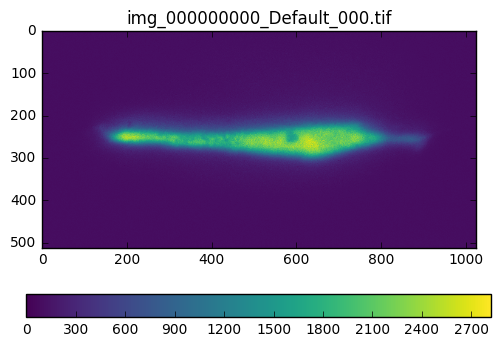

In [60]:
browse_images(datafiles)

We notice the following:

* the images contain **large areas of background**, which are not of interest for the analysis and can be cropped.

* the **shape of the cell changes** or the cell moves out of focus in the second half of the time series. This part will need to be discarded.

* the sample shows **strong photobleaching**, i.e. the fluorophore molecules (EGFP) are altered in the course of the acquisition such that it permanently is unable to fluoresce. This decay in intensity needs to be corrected before calculating the pair correlations.

### Select image regions of interest

To select regions of images that contain objects, we use the morphology and segmentation functions of the  [scikit-image](http://scikit-image.org/) library.

The image is **smoothed** using a Gaussian filter and then **binarized** by an intensity threshold. Small **holes are closed** and **border artifacts removed**. Connected **regions are labeled** and sorted by their area. **Small regions are discarded** and the remaining regions expanded to a multiple of 64 pixels:

In [61]:
import matplotlib

import skimage
import skimage.filters
import skimage.morphology
import skimage.segmentation
import skimage.restoration

# global variable where found regions will be stored
regions_found = []


def find_regions(files, modulo=(64, 64), imread=tifffile.imread):
    """Interactively find image regions."""

    def _imshow(fileindex=0, sigma=4.0, threshold=0.0, 
                closegaps=10, minsize=64*64):
        # read image
        image = imread(files[fileindex])
        
        # normalize image
        image = image.astype('float64')
        image -= image.min()
        image /= image.max()

        # remove noise by smoothing with Gaussian filter
        image = skimage.filters.gaussian(image, sigma)

        # binarize image with intensity threshold
        if threshold == 0.0:
            threshold = image.mean()
            # skimage.filters offers many threshold_* functions:
            #     otsu, li, yen, adaptive, and isodata
        binary = image > threshold

        # close small gaps
        binary = skimage.morphology.closing(
            binary, skimage.morphology.square(closegaps))

        # remove artifacts connected to image border
        skimage.segmentation.clear_border(binary)

        # label image regions
        labels = skimage.measure.label(binary)

        # discard small regions
        regions = (r for r in skimage.measure.regionprops(labels)
                   if r.area > minsize)

        # sort regions by area
        regions = reversed(sorted(regions, key=lambda x: x.area))
        
        def expand_bbox(bbox, shape):
            # return bounding box expanded to multiple of modulo
            minrow, mincol, maxrow, maxcol = bbox
            div, mod = divmod(maxrow - minrow, modulo[0])
            if mod:
                minrow = max(0, minrow - mod//2)
                maxrow = min(shape[0]-1, minrow + (div+1)*modulo[0])
                minrow = max(0, maxrow - (div+1)*modulo[0])
            div, mod = divmod(maxcol - mincol, modulo[1])
            if mod:
                mincol = max(0, mincol - mod//2)
                maxcol = min(shape[1]-1, mincol + (div+1)*modulo[1]) 
                mincol = max(0, maxcol - (div+1)*modulo[1])
            return minrow, mincol, maxrow, maxcol
        
        # keep only bounding box of regions
        regions = [expand_bbox(r.bbox, image.shape) for r in regions]

        # plot image and regions
        pyplot.imshow(image.T, vmin=0.0, vmax=1.0, cmap='viridis')
        ax = pyplot.gca()
        for region in regions:
            minrow, mincol, maxrow, maxcol = region
            rect = matplotlib.patches.Rectangle(
                (minrow+1, mincol+1), maxrow-minrow-2, maxcol-mincol-2,
                fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
        #pyplot.colorbar(orientation='horizontal')
        pyplot.show()
        
        # store regions in global variable
        global regions_found
        regions_found = regions
        return regions
    
    widgets.interact(_imshow, 
                     fileindex=(0, len(files)-1), 
                     sigma=(0.1, 16.0, 0.1),
                     threshold=(0.0, 1.0, 0.01),
                     closegaps=(1, 20),
                     minsize=(1, 256*256))

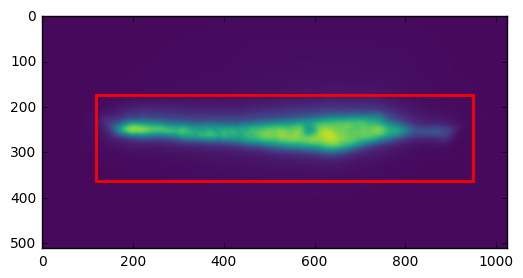

[(118, 172, 950, 364)]

In [62]:
find_regions(datafiles)

### Save region from SPIM files as ImageJ hyperstack

For further analysis, we extract the selected region from all files and save them to an ImageJ hyperstack file using the [tifffile](http://www.lfd.uci.edu/~gohlke/code/tifffile.py.html) module.

[ImageJ hyperstacks](https://imagej.nih.gov/ij/docs/guide/146-8.html#fig:Stacks-and-Hyperstacks) are non-conformant TIFF files that store one up to 6-dimensional image in one contiguous strip. 

The contiguous image data in the ImageJ hyperstack file can be **[memory-mapped](https://en.wikipedia.org/wiki/Memory-mapped_file)** to a numpy array, which has significant advantages over accessing thousands of individual files:

1. less overhead parsing individual TIFF files

2. **increased I/O performance** because of operating system optimizations

3. Numpy can access small segments of the data on disk **without reading the entire file into main memory**.

Let's save the selected region from the first 20,000 images of the time series to a ImageJ hyperstack: 

In [63]:
import tifffile

def region2tiff(filename, datafiles, region, imread=tifffile.imread):
    """Write region from datafiles to TIFF file."""
    minrow, mincol, maxrow, maxcol = region
    
    with tifffile.TiffWriter(filename, imagej=True) as tif:
        for fname in datafiles:
            image = imread(fname)
            image = image[minrow:maxrow, mincol:maxcol]
            image.shape = (1, 1, 1) + image.shape + (1,)  # make 6D
            tif.save(image, metadata={'pos': (minrow, mincol)})

In [64]:
%time region2tiff(datafile, datafiles[:20000], regions_found[0])
print("%s  (%.1f GB)" % (datafile, os.path.getsize(datafile) / 1024**3))

Wall time: 34.6 s
./nih3t3-egfp_2_roi0.tif  (6.0 GB)


D:\Temp\BigDIPA_ipcf\tifffile.py:1024: UserWarning: truncating ImageJ file
  warnings.warn("truncating ImageJ file")


The `UserWarning` indicates that the saved ImageJ file is a no-standard TIFF file.

The data from the ImageJ hyperstack can be accessed as a memory mapped numpy array. Beware that any change to the memory-mapped numpy array will change the data stored in the TIFF file.

In [65]:
def memmap_imagej(filename):
    """Return memory-mapped numpy array from ImageJ hyperstack.
    
    Changes to the returned array will change the data stored 
    in the TIFF file.
    
    """
    with tifffile.TiffFile(filename) as tif:
        assert tif.is_imagej
        page = tif.pages[0]
        shape = page.shape
        dtype = page.dtype
        offset = page.strip_offsets[0]

    return numpy.memmap(filename, shape=shape, dtype=dtype,
                        offset=offset, mode='r+')

In [66]:
%time spim_data = memmap_imagej(datafile)
print(spim_data.shape)

Wall time: 973 µs
(20000, 832, 192)


Let's interactively plot the extracted images in the memory-mapped 3D array:

In [67]:
def imshow_ts(data, vmin=0, vmax=None):
    """Interactively plot images in time series."""
    def _imshow(index=0):
        image = data[index]
        pyplot.imshow(image.T, vmin=vmin, vmax=vmax, cmap='viridis')
        pyplot.colorbar(orientation='horizontal')
        pyplot.show()
    
    widgets.interact(_imshow, index=(0, data.shape[0]-1, 100))

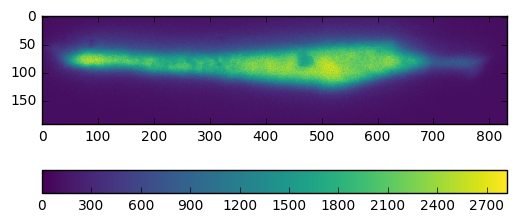

In [68]:
imshow_ts(spim_data)    

### Correct for photobleaching

As noted before the sample shows strong photobleaching, which needs to be corrected before correlation analysis.

The exponential decay of the fluorescence intensity due to photobleaching is visualized by plotting the time series of selected pixels:

In [69]:
import math

def plot_ts(data, ymax=None):
    """Interactively plot time series at pixel."""
    ntimes, height, width = data.shape
    pow2 = int(math.log(ntimes, 2))
    t = numpy.arange(ntimes)
    
    def _plot(y, x, start=0, pow2=pow2):
        pyplot.title("time series")
        pyplot.xlabel('time index')
        pyplot.ylabel('intensity')
        stop = min(start + 2**pow2, ntimes)
        pyplot.plot(t[start:stop], data[start:stop, y, x])
        pyplot.gca().set_xlim([start, stop-1])
        pyplot.gca().set_ylim([0, ymax])
        pyplot.show()

    widgets.interact(_plot, y=(0, height-1), x=(0, width-1), 
                     start=(0, ntimes-2**4, 100), pow2=(4, pow2, 1))

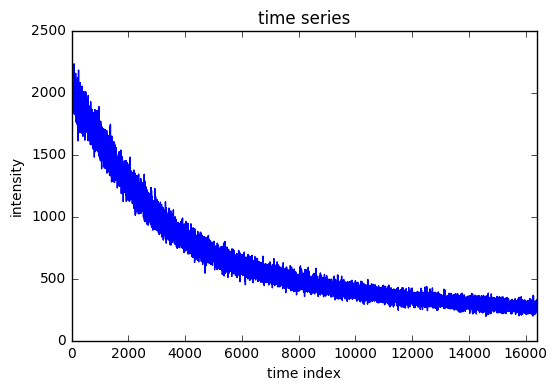

In [70]:
plot_ts(spim_data, ymax=2500)

To correct for bleaching, we **subtract the smoothed time series from themselves** and **add the signal mean**. The double exponential smoothing algorithm is the same as used for smoothing the log-binned cross-correlation functions:

In [71]:
%%cython --compile-args=/openmp --link-args=-fopenmp

# with gcc use `--compile-args=-fopenmp `

#cython: boundscheck=False
#cython: wraparound=False
#cython: cdivision=True

import numpy

from cython.parallel import prange, parallel

cimport numpy
from libc.stdlib cimport malloc, free
from libc.math cimport round

ctypedef numpy.uint16_t uint16_t


cdef inline void highpass_filter(uint16_t[:] data, double *a, 
                                 ssize_t size, int m) nogil:
    """Inline subtract smoothed vector and add mean.
    
    Using double exponential smoothing with factor 1/m.
    
    """
    cdef ssize_t i
    cdef double f0 = 1.0 / <double>m
    cdef double f1 = 1.0 - f0
    cdef ssize_t sumd = data[0]
    cdef uint16_t d
    cdef double t
    
    a[0] = data[0]
    for i in range(1, size):
        d = data[i]
        sumd += d
        a[i] = <double>d * f0 + a[i-1] * f1
    for i in range(size-2, -1, -1):
        a[i] = a[i] * f0 + a[i+1] * f1
        
    cdef double mean = sumd / size
    
    for i in range(size):
        t = round(mean + (<double>data[i] - a[i]))
        if t < 0.0:
            t = 0.0
        elif t > 65535.0:
            t = 65535.0
        data[i] = <uint16_t>t


def correct_bleaching(numpy.ndarray[uint16_t, ndim=3] image_timeseries, 
                      ssize_t m=1024, int num_threads=0):
    """Inline correct time series for exponential photobleaching.
    
    The first and last 'm' samples of 'image_timeseries' should not 
    be used after applying this function.

    """
    cdef uint16_t[:, :, ::] data = image_timeseries
    cdef ssize_t ntimes = data.shape[0]
    cdef ssize_t height = data.shape[1]
    cdef ssize_t width = data.shape[2]
    cdef ssize_t t, y, x   
    cdef double *a_
    
    if 2*m > ntimes:
        raise ValueError("smoothing factor m is too large")

    with nogil, parallel(num_threads=num_threads):
        
        # thread-local input/output data
        a_ = <double *>malloc(sizeof(double) * ntimes)
        if not a_:
            with gil:
                raise MemoryError("could not allocate a_")

        for y in prange(height):
            for x in range(width):
                highpass_filter(data[:, y, x], a_, ntimes, m)
                    
        free(a_)
    
    if hasattr(image_timeseries, 'flush'):
        # flush changes to memory-mapped file
        image_timeseries.flush()

In [72]:
%time correct_bleaching(spim_data, m=1024)

Wall time: 1min 12s


The time series of images is now corrected for photobleaching:

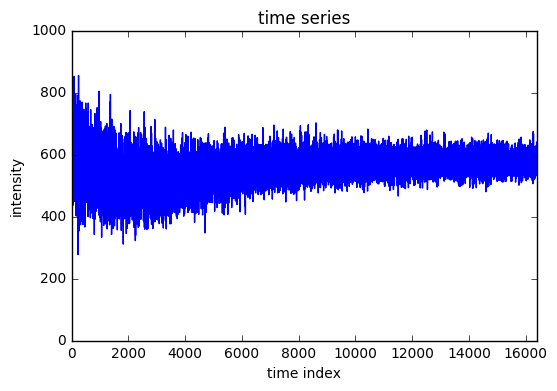

In [73]:
plot_ts(spim_data, ymax=1000)

For the pair correlation analysis of the image, we will **discard the first 2000 samples** and use the next 2<sup>14</sup> samples.

In [74]:
spim_data = spim_data[2000: 2000+2**14]

print("shape =", spim_data.shape)
print("size = %.2f GB" % (spim_data.size / 2**29))

shape = (16384, 832, 192)
size = 4.88 GB


### Out-of-core analysis using Dask

A multi-gigabyte image time series is too large to be analyzed by the ipfc function because it exceeds the available main memory on our personal computer.

We can use the [Dask](http://dask.pydata.org) library to **chop the image in smaller blocks/chunks** and **schedule the analysis of individual blocks** based on available memory, CPU cores or cluster nodes. 

Dask also supports **overlapping blocks** (ghost cells) where the borders between neighboring blocks overlap, as required for the pair correlation analysis:

![ghosted-blocks](ghosted-blocks.png)

**Operations on dask arrays are lazy and are queued**. No computations are performed until values are requested to be computed. 

Dask can work with **arrays on disks** such as arrays stored in HDF5 and memory-mapped binary files. Only when computations are performed are data loaded into memory.

Dask provides **serial, threaded, multiprocessing and distributed schedulers** that scale from laptop computers to clusters of computers. The default scheduler is threaded, which works well for our task.

In [75]:
import math
import dask.array as da


def run_ipcf_blocked(ipcf_function, image_timeseries, 
                     radius=6, npoints=32, nbins=32,
                     chunks=(32, 32), num_workers=4,
                     **kwargs):
    """Run ipcf_function on small overlapping blocks of image_timeseries."""
    ntimes, height, width = image_timeseries.shape
   
    # truncate time axis to power of two
    ntimes = 2**int(math.log(ntimes, 2))
    image_timeseries = image_timeseries[:ntimes]
    
    # calculate circle coordinates
    circle_coordinates = circle(radius, npoints)
    
    # calculate log-bins
    bins = logbins(ntimes // 2, nbins)
    nbins = bins.size
   
    # create dask ghost arrays and map function
    data = da.from_array(image_timeseries, 
                         chunks=(ntimes, chunks[0], chunks[1]))
    
    # create dask ghost array of overlapping blocks
    # set the image boundaries to 1
    data = da.ghost.ghost(data, depth=(0, radius, radius), boundary=(0, 1, 1))
    
    result = da.core.map_blocks(
        ipcf_function,
        data,
        dtype='float32',
        chunks=(chunks[0], chunks[1], npoints, nbins),
        drop_axis=0,
        new_axis=[2, 3],
        circle_coordinates=circle_coordinates, 
        bins=bins,
        **kwargs
        ).compute(num_workers=num_workers)
    
    # trim the borders from the result
    result = result[radius:-radius, radius:-radius]
    
    return result

The `run_ipcf_blocked` function returns the computed results as a numpy array in memory. For larger datasets we would need to write block results directly to disk.

We test the blocked ipcf analysis on the simulated dataset:

In [76]:
%time ipcf_result = run_ipcf_blocked(ipcf_cython, simulated_data)
test_ipcf(ipcf_result)

Wall time: 2.32 s


### Run pair correlation analysis on SPIM image time series

Finally, we run the pair correlation analysis on the region of interest extracted from the SPIM images and corrected for photobleaching. 

We'll use chunks of 64x64 pixels and half of the CPU cores. Each chunk uses ~400 MB RAM and the result array uses 540 MB. The size of chunks and number of worker threads should be adjusted based on the image size and available main memory and CPU cores:

In [77]:
from multiprocessing import cpu_count

%time ipcf_spim_result = run_ipcf_blocked(ipcf_cython, \
                                          spim_data, \
                                          chunks=(64, 64), \
                                          num_workers=cpu_count()//2, \
                                          num_threads=2)

Wall time: 1min 18s


The results can be visualized using the previously defined interactive `plot_ipcf_sprites` and `plot_ipcf_images` functions:

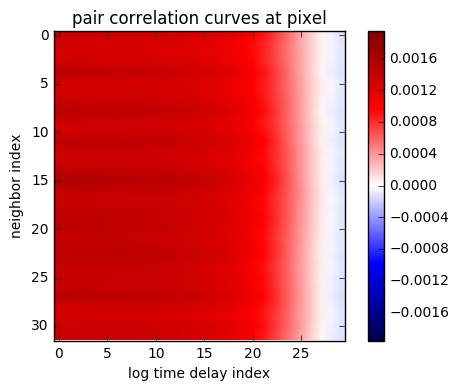

In [78]:
plot_ipcf_sprites(ipcf_spim_result)

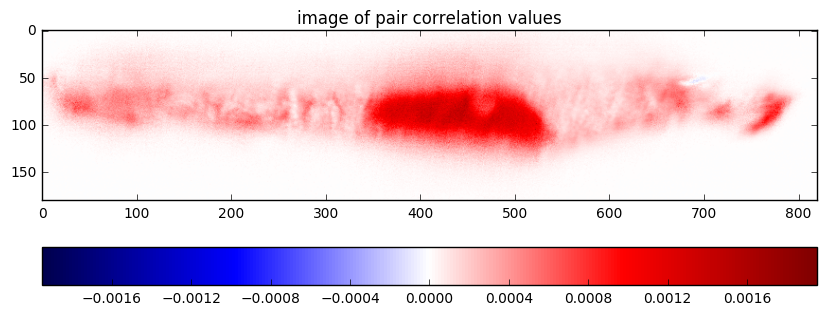

In [79]:
plot_ipcf_images(ipcf_spim_result, figsize=(10, 4))

The results from the image pair correlation are saved as a binary file that can be analyzed with [Globals for Images · SimFCS](http://www.lfd.uci.edu/globals/) software:

In [80]:
ipcf_spim_result.tofile(resultfile)
print(resultfile, ipcf_spim_result.shape, ipcf_spim_result.dtype)

./nih3t3-egfp_2_roi0.tif.ipcf.bin (820, 180, 32, 30) float32



---
## References

### Image pair correlation analysis

* Carmine Di Rienzo, Enrico Gratton, Fabio Beltram, and Francesco Cardarelli. [Spatiotemporal fluctuation analysis: a powerful tool for the future nanoscopy of molecular processes](https://doi.org/10.1016/j.bpj.2016.07.015). Biophys J. 2016; 111(4): 679-685. PMCID: PMC5002078

* Carmine Di Rienzo, Francesco Cardarelli, Mariagrazia Di Luca, Fabio Beltram, and Enrico Gratton. [Diffusion tensor analysis by two-dimensional pair correlation of fluorescence fluctuations in cells](https://doi.org/10.1016/j.bpj.2016.07.005). Biophys J. 2016; 111(4): 841-851. PMCID: PMC5002073

* Enrico Gratton. [Globals software tutorial - 2D pair correlation function analysis](http://www.lfd.uci.edu/globals/tutorials/) (2016) [Online]

### Scientific Computing in Python

* Python Software Foundation. [The Python Programming Language](http://www.python.org) (2016) [Online]

* Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. [The NumPy Array: A Structure for Efficient Numerical Computation](https://doi.org/10.1109/MCSE.2011.37). Computing in Science & Engineering, 13, 22-30 (2011)

* John D. Hunter. [Matplotlib: A 2D Graphics Environment](https://doi.org/10.1109/MCSE.2007.55), Computing in Science & Engineering, 9, 90-95 (2007)

* Jones E, Oliphant E, Peterson P, et al. [SciPy: Open Source Scientific Tools for Python](http://www.scipy.org/) (2016) [Online]

* Siu Kwan Lam, Antoine Pitrou, and Stanley Seibert. [Numba: A LLVM-based Python JIT Compiler](https://doi.org/10.1145/2833157.2833162). Proceedings of the Second Workshop on the LLVM Compiler Infrastructure in HPC. Article No. 7 (2015)

* Fernando Pérez and Brian E. Granger. [IPython: A System for Interactive Scientific Computing](https://doi.org/). Computing in Science & Engineering, 9, 21-29 (2007)

* Stefan Behnel, Robert Bradshaw, Craig Citro, Lisandro Dalcin, Dag Sverre Seljebotn and Kurt Smith. [Cython: The Best of Both Worlds](https://doi.org/10.1109/MCSE.2010.118), Computing in Science and Engineering, 13, 31-39 (2011)

* Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. [scikit-image: Image processing in Python](https://doi.org/10.7717/peerj.453). PeerJ 2:e453 (2014)

* Matthew Rocklin. [Dask: Parallel Computation with Blocked algorithms and Task Scheduling](http://conference.scipy.org/proceedings/scipy2015/matthew_rocklin.html). Proceedings of the 14th Python in Science Conference, Scipy2015 (2015)

## System information

Print information about hardware and software used to generate this document:

In [81]:
import sys
import datetime
import multiprocessing
from distutils import ccompiler
import notebook

print()
print('Python', sys.version)
for item in ('IPython.__version__', 
             'notebook.__version__',
             'numpy.__version__',
             'scipy.__version__',
             'matplotlib.__version__',
             'numba.__version__',
             'Cython.__version__', 
             'dask.__version__',
             'pandas.__version__',
             'tifffile.__version__',
            ):
    module, version = item.split('.')
    try:
        lib = sys.modules[module]
    except KeyError:
        try:
            __import__(module)
        except ImportError:
            continue
    print(module, getattr(lib, version))

print()
print("Compiler type:", ccompiler.new_compiler().compiler_type)
print()
print(multiprocessing.cpu_count(), "CPU cores")

try:
    import psutil
    print("{:.0f} GB main memory".format(psutil.virtual_memory()[0] / 2**30))
except ImportError:
    pass
    
print()
print(datetime.datetime.now())


Python 3.5.2 (v3.5.2:4def2a2901a5, Jun 25 2016, 22:18:55) [MSC v.1900 64 bit (AMD64)]
IPython 5.1.0
notebook 4.2.3
numpy 1.11.2
scipy 0.18.1
matplotlib 1.5.3
numba 0.28.1
Cython 0.24.1
dask 0.11.1
pandas 0.19.0
tifffile 2016.06.21

Compiler type: msvc

12 CPU cores
128 GB main memory

2016-10-19 00:52:09.056273
